In [1]:
import numpy as np
import time
import scipy
from scipy.special import expit
import pandas as pd
from sklearn.metrics import accuracy_score
import oracles

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    
    def __init__(self, loss_function, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
                
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход 
        
        max_iter - максимальное число итераций     
        
        **kwargs - аргументы, необходимые для инициализации   
        """
        self.loss_function = loss_function
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.l2_coef = kwargs.get('l2_coef')
        if self.loss_function == 'binary_logistic':
            self.loss = oracles.BinaryLogistic(kwargs['l2_coef'])
        self.w = np.array([])
        self.history = {'time': [0.], 'func': []}
        
    def fit(self, X, y, w_0=None, trace=False):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w_0 - начальное приближение в методе
        
        trace - переменная типа bool
      
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)
        
        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        self.y = y.copy()
        self.w = w_0.copy()
        step = 1
        time_new = time.time()
        while True:
            loss_prev = self.loss.func(X, y, self.w)
            print(loss_prev)
            grad = self.loss.grad(X, y, self.w)
            self.w -= self.step_alpha / step ** self.step_beta * grad 
            
            loss_next = self.loss.func(X, y, self.w)
            
            step += 1
            
            self.history['time'].append(time.time() - time_new)
            time_new = time.time()
            self.history['func'].append(loss_prev)
            
            if np.abs(loss_prev - loss_next) < self.tolerance or step > self.max_iter :
                self.history['func'].append(loss_next)
                if trace:
                    return self.history
                else:
                    return
        
    def predict(self, X):
        """
        Получение меток ответов на выборке X
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: одномерный numpy array с предсказаниями
        """
        return np.array(list(map(round, self.predict_proba(X)))) * 2 - 1

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k 
        """
        return expit(X.dot(self.w))
        
    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: float
        """
        return self.loss.func(X, y, self.w)
        
    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: numpy array, размерность зависит от задачи
        """
        return self.loss.grad(X, y, self.w)
    
    def get_weights(self):
        """
        Получение значения весов функционала
        """    
        return self.w



In [4]:
class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    
    def __init__(self, loss_function, batch_size, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        
        batch_size - размер подвыборки, по которой считается градиент
        
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход 
        
        
        max_iter - максимальное число итераций (эпох)
        
        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.
        
        **kwargs - аргументы, необходимые для инициализации
        """
        self.loss_function = 'binary_logistic'
        self.batch_size = batch_size
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_seed = random_seed
        self.l2_coef = kwargs.get('l2_coef')
        if self.loss_function == 'binary_logistic':
            self.loss = oracles.BinaryLogistic(kwargs['l2_coef'])
        self.w = np.array([])
        self.history = {'epoch_num': [], 'time': [0.], 'func': [], 'weights_diff': [0.], 'loss': []}
        
    def fit(self, X, y, w_0=None, trace=True, log_freq=1):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
                
        w_0 - начальное приближение в методе
        
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет 
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}
        
        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления. 
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.
        
        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """
        np.random.seed(self.random_seed)
        self.y = y.copy()
        self.w = w_0.copy()
        new_w = self.w
        step = 1
        time_new = time.time()
        epoch_freq = 0.
        epoch_num = 0.
        while True:
            loss_prev = self.loss.func(X, y, self.w)
            print(loss_prev)
            rand_indexes = np.random.choice(range(self.y.shape[0]), 
                                            self.batch_size, replace=False)
            
            X_subset = X[rand_indexes]
            y_subset = y[rand_indexes]
            
            grad = self.loss.grad(X_subset, y_subset, self.w)
            self.w -= self.step_alpha / step ** self.step_beta * grad 
            
            loss_next = self.loss.func(X, y, self.w)
            self.history['loss'].append(loss_prev)
            epoch_freq += self.batch_size /  self.y.shape[0]
            epoch_num += self.batch_size /  self.y.shape[0]
            
            if trace and epoch_freq > log_freq:
                epoch_freq = 0
                self.history['epoch_num'].append(epoch_num)
                self.history['time'].append(time.time() - time_new)
                time_new = time.time()
                self.history['func'].append(loss_prev)
                self.history['weights_diff'].append(np.linalg.norm(self.w - new_w))
                new_w = self.w
                step += 1
           
            if np.abs(loss_prev - loss_next) < self.tolerance or step > self.max_iter :
                self.history['func'].append(loss_next)
                self.history['loss'].append(loss_next)
                if trace:
                    return self.history
                else:
                    return
                
    def predict(self, X):
        """
        Получение меток ответов на выборке X
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: одномерный numpy array с предсказаниями
        """
        return np.array(list(map(round, self.predict_proba(X)))) * 2 - 1

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k 
        """
        return expit(X.dot(self.w))
        
    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: float
        """
        return self.loss.func(X, y, self.w)
        
    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: numpy array, размерность зависит от задачи
        """
        return self.loss.grad(X, y, self.w)
    
    def get_weights(self):
        """
        Получение значения весов функционала
        """    
        return self.w


## 1. Проверим общую работу градиентного спуска на сгенерированной выборке.

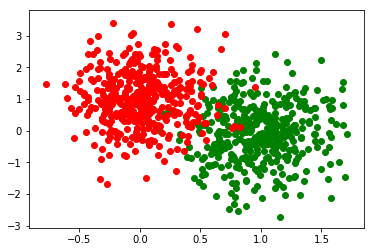

In [5]:
mu_1_0 = 1
mu_1_1 = 0
sigma_1 = 0.3

mu_0_0 = 0
mu_0_1 = 1
sigma_0 = 0.3

np.random.seed(0) 

X_1 = np.random.normal(mu_1_0, sigma_1, (395, 1)) 

Y_1 = np.random.normal(mu_1_1 , sigma_1 * 3, (395, 1)) 


X_0 = np.random.normal(mu_0_0, sigma_0, (395, 1)) 

Y_0 = np.random.normal(mu_0_1 , sigma_0 * 3, (395, 1)) 

plt.scatter(X_1, Y_1, color = 'g') 
plt.scatter(X_0, Y_0, color = 'r') 

In [6]:
X = np.concatenate((X_1, X_0))
Y = np.concatenate((Y_1, Y_0))

In [7]:
dataset = np.concatenate((X, Y), axis=1)

In [8]:
labels = np.array([1 if i in range(X_1.shape[0]) else -1 for i in range(X.shape[0])])

In [9]:
clf = SGDClassifier(loss_function='binary_logistic', batch_size=2, step_alpha=0.01, step_beta=0, 
                 tolerance=1e-5, max_iter=10, random_seed=153, l2_coef=0.01)

In [10]:
h_clf = clf.fit(dataset, labels, np.array([-1.,1.]))

1.4242392044384848
1.4214109931164502
1.418496062290744
1.412559972451058
1.4092255105699827
1.399401143947693
1.3959444947957993
1.3943848620680612
1.3926494886882634
1.3894848119423902
1.3896305246951393
1.3829173456617894
1.3796397130397648
1.379826967948414
1.3738187135623985
1.3667092278004183
1.3588371179411716
1.352431569721278
1.352231900053433
1.3487680118329475
1.3464946267546667
1.3439742168323492
1.3354970194492664
1.3307454415432531
1.329293899113511
1.3210820872835425
1.3154222742451906
1.3140603851082935
1.3113310724980949
1.3077533927497347
1.2994106569250379
1.2950250212641679
1.2915103088309325
1.2880896153167578
1.2838467408145895
1.283113214201428
1.280283594596061
1.2748457845513699
1.2760486998269156
1.2752490877260656
1.2733797711890955
1.2726052824919083
1.272393854409515
1.2644145994159366
1.2561518453833116
1.248224091864837
1.2431687034157621
1.2439732447317209
1.2411942820479107
1.2353043817634257
1.2294641150308685
1.226355917231642
1.223622298799754
1.2219

In [11]:
line_x = np.linspace(-1, 2.0, num=1000)
line_y = [ - clf.w[0] / clf.w[1] * x for x in line_x]

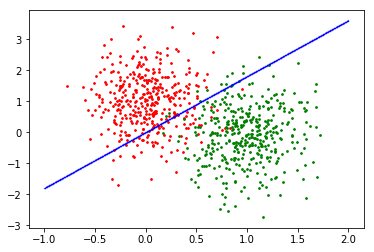

In [12]:
plt.scatter(X_0, Y_0, color = 'r', s =3) 
plt.scatter(X_1, Y_1, color = 'g', s =3) 
plt.scatter(line_x, line_y, color = 'b', s =0.1)

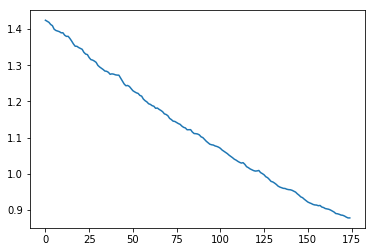

In [13]:
plt.plot(clf.history['loss'])

## Хорошо работает!

## 2. Обучим с помощью стахастического градиентного спуска и BagOfWords. 

In [14]:
df = pd.read_csv('toxic_train.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52061 entries, 0 to 52060
Data columns (total 3 columns):
Unnamed: 0      52061 non-null int64
comment_text    52061 non-null object
is_toxic        52061 non-null bool
dtypes: bool(1), int64(1), object(1)
memory usage: 864.4+ KB


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
fd_train_BW = vectorizer.fit_transform(df['comment_text'])


In [17]:
df.loc[df['is_toxic'] == False, 'is_toxic'] = -1
df.loc[df['is_toxic'] == True, 'is_toxic'] = 1

In [18]:
comments_clf_BW = SGDClassifier(loss_function = 'binary_logistic', batch_size=32, step_alpha=0.1, step_beta=0.01, 
                 tolerance=1e-5, max_iter=5, random_seed=153, l2_coef=0.01)

In [19]:
h = comments_clf_BW.fit(fd_train_BW, np.array(df['is_toxic']), np.random.normal(0, 0.1, fd_train_BW.shape[1]))

5.382327171438956
5.333513087222116
5.267859367252555
5.250298790839098
5.236288806760333
5.227177967935733
5.209319025672197
5.19464836707691
5.174102798856582
5.168397836713
5.154121103763528
5.141086675778666
5.148042571004316
5.13841685013013
5.105220341341494
5.16810470486887
5.124296914906659
5.069690121395474
5.062569744495741
5.06680338676003
5.119224227448946
5.038134586454811
5.014598267241722
5.021362853075571
4.994500520608068
4.981762989077105
4.974678386146873
4.966030849102097
4.958099644801507
4.951790986663357
4.943263371095007
4.930962333545137
4.927352395409492
4.93037892338608
4.912707538243403
4.897715827236166
4.874960710488042
4.864179476103604
4.855284384636301
4.84508931657008
4.836693460974798
4.82781642885285
4.817344383944
4.80884040095655
4.811159431697656
4.791615661327468
4.780030959243105
4.77189412137461
4.7634333974723
4.75309208567867
4.745598948089664
4.7338866409501605
4.724274856954072
4.718696374379016
4.71461075517195
4.698506167920751
4.68838447

2.473945006045997
2.473401642979009
2.468186252615273
2.465348183918666
2.4573519585313646
2.453139859561074
2.447209146991073
2.438700618854705
2.438679157488316
2.431518919250764
2.427500454728757
2.4219807686355104
2.4172758733853645
2.4138660994025263
2.411757321144358
2.4081486228035582
2.4037826682147974
2.3991511855096688
2.395583395271815
2.3927937905337915
2.391163442454686
2.3839153436511955
2.380566564978116
2.376544520737071
2.373918600842486
2.369527534865827
2.365271969812167
2.361838844836262
2.3578975841136063
2.3588243309740653
2.3542830230517406
2.3515301574346883
2.343235561448899
2.400329455605098
2.340716736814747
2.331608619859484
2.3258812954067154
2.321934653775526
2.3189534379894745
2.320181831634628
2.3118449462564845
2.307508850900706
2.3112476824779793
2.306452416128447
2.3027256394283246
2.3035936750237234
2.2995095323480275
2.2857041894464745
2.2820207765130966
2.278012881527525
2.272994107331694
2.269059602648444
2.26498660109153
2.2602710678326186
2.2579

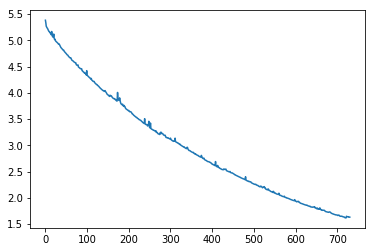

In [21]:
plt.plot(comments_clf_BW.history['loss'])

### Посмотрим ошибку на тестовой выборке.

In [22]:
df_test = pd.read_csv('toxic_test.csv')

In [23]:
df_test.loc[df_test['is_toxic'] == False, 'is_toxic'] = -1
df_test.loc[df_test['is_toxic'] == True, 'is_toxic'] = 1

In [24]:
transormed_df_test_BW = vectorizer.transform(df_test['comment_text'])

In [26]:
pred_y_test_BW = comments_clf_BW.predict(transormed_df_test_BW)

### accuracy:

In [28]:
accuracy_score(np.array(df_test['is_toxic']), pred_y_test_BW)

0.81094022054556

## 3. Используем Tfidf.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
transformed_df_train_Tf_idf = vectorizer.fit_transform(df['comment_text'])


In [30]:
transormed_df_test_Tf_idf = vectorizer.transform(df_test['comment_text'])

In [31]:
comments_clf = SGDClassifier(loss_function = 'binary_logistic', batch_size=32, step_alpha=0.1, step_beta=0.01, 
                 tolerance=1e-5, max_iter=5, random_seed=153, l2_coef=0.01)

In [32]:
h = comments_clf.fit(transformed_df_train_Tf_idf, np.array(df['is_toxic']),
                     np.random.normal(0, 0.1, transformed_df_train_Tf_idf.shape[1]))

5.278004489340051
5.268633113452911
5.2591664634880235
5.249876308915038
5.240593648159148
5.23124815077434
5.221984609804667
5.212609272676248
5.203315423829789
5.193910075423693
5.184750042204708
5.175539232338947
5.16633908443502
5.157201993791244
5.148049835606983
5.139035757262672
5.129992866235955
5.120993714878244
5.111852586348082
5.10292628780851
5.09401053487289
5.084988722054615
5.075948508613435
5.066847465987843
5.057960521052144
5.049018658673765
5.0400896164850195
5.031172784209521
5.022374191422818
5.013612322650442
5.004816934247748
4.996072577924339
4.987286268528072
4.978521163079546
4.969861127889463
4.961091418986051
4.952238861288899
4.9435569594664495
4.934872464075678
4.926211060582185
4.9175022547857585
4.908834040743908
4.9002609967480035
4.891685156116319
4.882957513019305
4.8743107876209555
4.865666740025517
4.857156778181734
4.8486741941410925
4.840165238285349
4.831696222990913
4.823239600413996
4.814710115455458
4.806147484974409
4.797631157324685
4.78937

2.4946794023016166
2.4909488155922173
2.4872119764431395
2.4835045339250987
2.4797861351755284
2.476065341132867
2.4723836864432442
2.46866001735604
2.4649881719456896
2.4612790797750046
2.4576195678108235
2.4539359016773803
2.450298412118784
2.446626889171829
2.442966123645628
2.439326801407336
2.435714859990196
2.432041523179665
2.4284364496614836
2.4248253698246045
2.4212252917829438
2.417618334298327
2.414068388416057
2.410468298632508
2.4068857675958393
2.403367623380715
2.3998329146195596
2.3962744890134053
2.3927188497904566
2.3891297731476326
2.3855853059910372
2.382083942815667
2.3785690944103997
2.375099927609368
2.3716153900538135
2.3680859041151767
2.3645881132902726
2.3610965627699456
2.3576269257727605
2.3541358278728177
2.3506765247419503
2.347261218436121
2.343818562272825
2.3404017485281154
2.3370196875042946
2.333612046346593
2.3301915933283452
2.3268069358286123
2.3233799505651263
2.3199888547534795
2.316584710258741
2.3132151901950975
2.3098213681695405
2.3064556403

1.392069650708786
1.390542374733101
1.3890377422082643
1.3875037759723448
1.3860023436082358
1.3844983383998386
1.3829936815642052
1.3814826372412172
1.3799703820120757
1.378470416840837
1.3769729736899299
1.3754809880827845
1.3739768035998312
1.3724710398250797
1.3709771293176314
1.3695038255647365
1.368024133754711
1.366528284950162
1.3650587592121481
1.3635830153624529
1.3621184091439194
1.3606475080759546
1.3591844271359705
1.3577118079338992
1.356248786734198
1.354782861160058
1.353324248876301
1.3518810870401214
1.3504466304755076
1.3490020216253809
1.3475595138942902
1.346135761508905
1.3446953811985172
1.343271241254886
1.341860486267295
1.34043946359352
1.339010661314293
1.3375872084083686
1.3361827189848772
1.3347673133554034
1.3333508095889877
1.3319515370290884
1.3305278887502026
1.3291285900479017
1.3277296722656646
1.3263473954912983
1.3249570956210421
1.3235670253997887
1.3221829580415942
1.3208022134493058
1.3194186920320694
1.3180259670619865
1.3166451501521124
1.31526

0.9465336661769026
0.9459070477546778
0.9452705299611981
0.9446451032503815
0.9440173791356734
0.9433899740144319
0.9427664452412474
0.9421416681151975
0.9415136438788523
0.9408857031512967
0.9402675754635647
0.9396505842478352
0.9390378511515018
0.9384214401221243
0.9378043185222245
0.9371871969572063
0.9365706121114379
0.9359616794125486
0.9353504691690606
0.9347464318986081
0.934139926215685
0.9335345551722136
0.9329362130892096
0.9323328166584057
0.9317254088090929
0.9311235116716576
0.9305233188814376
0.9299282004106981
0.929327187014893
0.9287318434499574
0.9281322170613319
0.9275386198321188
0.9269477712720994
0.9263575837671278
0.9257625062264032
0.9251644562248478
0.9245728339277656
0.9239798717291761
0.9233895004887169
0.9228120292503856
0.9222298487756269
0.9216475721561757
0.9210701516945323
0.9204900757999172
0.9199072109536159
0.9193314349578259
0.9187489391027024
0.9181640011331202
0.9175778720073939
0.9170072773157613
0.916435030937739
0.9158610766367915
0.9152881278328

0.7624198550132484
0.7621569076364421
0.7618976598938226
0.7616391387795125
0.7613792680785287
0.7611198148701412
0.7608630381509913
0.7606060625325237
0.7603488203193174
0.760091095585918
0.7598336812785409
0.7595747952843825
0.7593189989965309
0.7590652629818868
0.7588086366337976
0.7585522186735676
0.7582977277283083
0.7580442759772559
0.7577908085673489
0.7575361973806749
0.7572834832792347
0.7570310977643762
0.7567804716912875
0.756531536286991
0.7562824501515757
0.7560343137181431
0.7557858591044726
0.7555396734800851
0.7552888026963532
0.7550420235969395
0.7547972108843852
0.7545511938776756
0.7543061403796097
0.7540612866943737
0.753813106239946
0.7535687284555046
0.7533232754904994
0.7530829317777556
0.7528410818611602
0.7526007481574558
0.752363251344105
0.7521216117615508
0.7518807730846281
0.7516393878611035
0.7513992420260762
0.7511615001724149
0.7509228237312261
0.7506839615802655
0.7504484470630988
0.7502117385768691
0.7499727966947995
0.7497374290353683
0.74949769803644

0.6861339037142055
0.6860248459299325
0.6859138729926608
0.685802664825082
0.6856899392703178
0.6855792279165551
0.6854716578464493
0.685361829661375
0.6852561388650328
0.6851466276218603
0.6850397708736876
0.6849335590185677
0.6848276733867631
0.6847221077280365
0.684616658969726
0.6845098285720123
0.684405308103543
0.6842993494467167
0.6841937235211647
0.68408676262496
0.6839801919135934
0.6838740861181326
0.6837669065942688
0.6836607056859516
0.6835570554643848
0.6834535330663738
0.6833496878647632
0.683241942295129
0.6831372057337967
0.6830315099108727
0.6829248865689979
0.6828227399505039
0.6827211157940353
0.6826217012090924
0.6825178873381476
0.682414107251292
0.6823122047733503
0.682210368523283
0.682108645256306
0.6820059688579682
0.6819034977569273
0.6817999436950267
0.681697250669493
0.6815961420543978
0.6814959317674005
0.6813946167937468
0.6812948056368481
0.6811943639311321
0.6810940982306641
0.6809928364924978
0.6808953908154384
0.6807994894824663
0.6807021740391046
0.68

0.6539193026849558
0.6538737319516366
0.653826151491008
0.6537815841556345
0.6537377018646761
0.6536914588603662
0.6536469024113701
0.6536020541204064
0.6535570213358428
0.6535115224543467
0.6534656608195727
0.653420560885146
0.65337557884653
0.6533316685640101
0.653289197473192
0.6532443162172612
0.6531998127627822
0.6531545334587991
0.6531089444912928
0.6530640523280618
0.6530202928262314
0.6529753495653071
0.6529305542156982
0.6528858580132748
0.6528428503938282
0.652798885592648
0.6527560933993224
0.6527127013021349
0.6526697891394707
0.6526252727953185
0.6525813933798866
0.6525372984538379
0.6524935472823157
0.6524503041796098
0.6524059604525261
0.6523632062938675
0.652320558455383
0.6522772059275577
0.6522354906250458
0.6521927072632898
0.6521494075446783
0.6521071147202626
0.6520660252565849
0.6520239408129526
0.65198050646407
0.6519373860270389
0.6518934937417118
0.6518524506155519
0.6518118735752803
0.6517702724607162
0.6517299678499173
0.651687446522944
0.6516457530183247
0.6

0.6404968282969363
0.6404788739222063
0.6404597981909472
0.6404414512106189
0.6404222469397843
0.640403100373853
0.6403840916185753
0.6403648420751811
0.6403461812319048
0.6403267965298282
0.6403082549425893
0.640289707073385
0.6402704275163668
0.6402514187823484
0.6402324278632553
0.6402139510157595
0.6401948903090684
0.6401773236937516
0.6401596655169557
0.6401412994191018
0.6401226235497813
0.6401038248946692
0.6400852455258439
0.6400658829331667
0.6400466395597444
0.6400277366447931
0.6400091530026255
0.6399901422573606
0.6399722498875543
0.6399541991247856
0.6399366160320711
0.6399188511276347
0.6399011699038114
0.6398829425422432
0.6398660526954467
0.6398489439867734
0.6398304598244102
0.6398133215995478
0.6397957704081769
0.6397775695638523
0.6397594944816546
0.6397417499500466
0.6397238771780819
0.6397067397723805
0.6396888171056815
0.6396718153489233
0.6396543921365168
0.6396376272002089
0.6396202873206603
0.639602834304556
0.6395857771255877
0.6395678455823606
0.6395511611339

In [33]:
pred_y_test_Tf_idf = comments_clf.predict(transormed_df_test_Tf_idf)

In [34]:
accuracy_score(np.array(df_test['is_toxic']), pred_y_test_Tf_idf)

0.7598181466434514

## 4. Пропробуем обучить с помощью простого градиентого спуска.

In [35]:
GD_cldf = GDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, l2_coef=0.1)

In [36]:
GD_cldf.fit(transformed_df_train_Tf_idf, np.array(df['is_toxic']),
            np.random.normal(0, 0.1, transformed_df_train_Tf_idf.shape[1]))

46.42295182911825
45.51267666950091
44.6205169724826
43.746112219706326
42.88910906755972
42.04916120438875
41.225929210553275
40.41908042126739
39.62828879216973
38.85323476756877
38.09360515131046
37.34909298021564
36.61939740003607
35.90422354387946
35.20328241305354
34.51629076028189
33.842970975243496
33.18305097239069
32.53626408099921
31.902348937406675
31.281049379395537
30.672114342678004
30.075297759440897
29.490358458909846
28.91706006989213
28.355170925259156
27.80446396832985
27.264716661117113
26.73571089440031
26.21723289958739
25.70907316233111
25.211026337864325
24.722891168020347
24.244470399904532
23.775570706184546
23.316002606966872
22.865580393228107
22.424122051770077
21.99144919166838
21.5673869721848
21.151764032114258
20.744412420537863
20.345167528954143
19.953868024760848
19.570355786060595
19.19447583776397
18.82607628896422
18.465008271558347
18.111125880089595
17.764286112787286
17.424348813779904
17.091176616458313
16.764634887966093
16.44459167479452
16

0.689441200986991
0.6893099891127915
0.6891813884495158
0.6890553470321198
0.6889318139297039
0.6888107392249323
0.6886920739938632
0.688575770286179
0.6884617811058099
0.6883500603919444
0.6882405630004164
0.6881332446854636
0.6880280620818479
0.6879249726873331
0.68782393484551
0.6877249077289638
0.6876278513227764
0.6875327264083574
0.6874394945475962
0.68734811806733
0.6872585600441206
0.6871707842893343
0.6870847553345191
0.6870004384170718
0.6869177994661917
0.6868368050891129
0.6867574225576107
0.6866796197947774
0.6866033653620596
0.6865286284465548
0.6864553788485614
0.686383586969374
0.6863132237993236
0.6862442609060567
0.6861766704230438
0.6861104250383212
0.6860454979834532
0.6859818630227169
0.6859194944424993
0.6858583670409083
0.6857984561175877
0.6857397374637377
0.6856821873523309
0.6856257825285266
0.6855705002002718
0.6855163180290931
0.6854632141210691
0.6854111670179841
0.6853601556886565
0.6853101595204416
0.6852611583109005
0.6852131322596395
0.6851660619603062


In [37]:
accuracy_score(np.array(df_test['is_toxic']), GD_cldf.predict(transormed_df_test_Tf_idf))


0.731717933836332

## 5. посчитаем по сетке гиперпараметры модели, чтобы выбрать лучшие.

In [ ]:
L = []

for alpha in [0.001, 0.01, 0.1]:
    for beta in [0.001, 0.01]:
        for l2_coef in [0.01, 0.1]:
            c = SGDClassifier(loss_function = 'binary_logistic', batch_size=32, step_alpha=alpha, step_beta=beta, 
                 tolerance=1e-5, max_iter=1, random_seed=153, l2_coef=l2_coef)
            c.fit(transformed_df_train_Tf_idf, np.array(df['is_toxic']),
                     np.random.normal(0, 0.1, transformed_df_train_Tf_idf.shape[1]))
            acc = accuracy_score(np.array(df_test['is_toxic']), c.predict(transormed_df_test_Tf_idf))
            L.append('alpha: {}, beta: {}, l2_coef: {}, accuracy: {}'.format(alpha, beta, l2_coef, acc))

5.268998335620227
5.268904711406909
5.268809899217896
5.268716498880641
5.2686232736435725
5.268529115356204
5.268435814033094
5.268341238606931
5.268247024121152
5.268151994521385
5.268058997848186
5.2679651853284275
5.267871311432061
5.267778060390933
5.267684157629966
5.267591267989042
5.267498050439251
5.267405244905152
5.267310789139484
5.267218371092484
5.26712585552313
5.267032034323269
5.2669376724934995
5.266842618430371
5.266749598165303
5.2666562411748545
5.26656255065636
5.266468685640273
5.266375700189036
5.266283003610205
5.266189946733206
5.266097216545139
5.266004015321787
5.265910750611792
5.2658180955377745
5.265724391571249
5.265629780307588
5.265536537347101
5.265443076583708
5.26534957771024
5.2652556929878465
5.2651621307149945
5.265068993098217
5.264975916124245
5.264880956131196
5.264786744474587
5.264692503107413
5.264599364260461
5.2645061014838905
5.264412339234287
5.264318901379589
5.264225592544677
5.264131174563462
5.264036215141864
5.263941350193164
5.263

5.226114177248696
5.226020602976881
5.225928371807026
5.22583507143638
5.225742052109722
5.225648049789278
5.225555803386851
5.225462382410565
5.225369557563799
5.225276716922901
5.225184618940736
5.2250899323199915
5.224997383261986
5.224904402254076
5.224811322967908
5.224717932198245
5.2246260758614955
5.224532292912617
5.224439369957383
5.2243475689316945
5.224255193435854
5.224162285411492
5.224069426476092
5.223974778210653
5.223881408975902
5.223788812934769
5.2236963714399876
5.223604566642654
5.223512238721917
5.223418076875346
5.223324519021684
5.223231637878564
5.223139095212221
5.223045297485614
5.222952492065237
5.222860439866894
5.2227680036182
5.22267588664051
5.2225842491492145
5.2224916308968306
5.222398643609171
5.2223068524620135
5.222213617114414
5.222120779586856
5.222027684811063
5.221935424796194
5.221842148324641
5.22174948319916
5.221657611836357
5.221564529901504
5.221470362949389
5.221377470214483
5.221284967037288
5.221191924561587
5.2211000758152135
5.22100

In [ ]:
L

In [ ]:
best_clf_Tf_idf_SGD = SGDClassifier(loss_function = 'binary_logistic', batch_size=32, step_alpha=0.1, step_beta=0.01, 
                 tolerance=1e-5, max_iter=5, random_seed=153, l2_coef=0.01)

In [ ]:
H_best_clf_Tf_idf_SGD = best_clf_Tf_idf_SGD.fit(transformed_df_train_Tf_idf, np.array(df['is_toxic']),
                     np.random.normal(0, 0.1, transformed_df_train_Tf_idf.shape[1]))

In [ ]:
df.loc[(np.array(df['is_toxic']) != best_clf_Tf_idf_SGD.predict(transformed_df_train_Tf_idf))]['comment_text']\
.iloc[8]